## Getting Started

- Download MapPLUTO data from [NYC DCP](https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_mappluto_24v1_1_shp.zip)
- Unzip the file and place contents in the `Data` directory at the root of this repo
- Make sure you have installed all requisite libraries by running `pip install -r requirements.txt` **_with your virtual environment activated_**. For guidance on setting up or activating your virtual environment, refer to the notes in [00_Getting_started](00_Getting_started.md).

## Goals
- Download data from NYC DCP's open data portal
- Load data from file
- Explore spatial and non-spatial elements of the dataset
- Visualize spatial and non-spatial elements of the dataset 


The following libraries will allow us to import and explore our data. Note that in some cases we import the entire library and even use a short-hand reference (e.g. `import geopandas as gpd`), while in other cases we only import submodules (e.g. `sklearn.cluster import KMeans`). This is largely a matter of preference, but importing submodules can help reduce memory usage and improve performance, especially when working with large datasets or in an app you've developed.

In [ ]:
# the bare minimum
import matplotlib.pyplot as plt  # for plotting
import geopandas as gpd  # for geospatial data handling
from matplotlib.lines import Line2D

# more advanced
from lonboard._map import Map
from lonboard._layer import PolygonLayer  # for mapping in 3D
from lonboard.colormap import (
    apply_categorical_cmap,
    apply_continuous_cmap,
)  # for assigning colors
from palettable.colorbrewer.sequential import PuRd_9  # for color palettes
from matplotlib.colors import LogNorm  # for logarithmic normalization
import pygwalker as pyg  # for creating interactive data visualizations

# Load PLUTO data


MapPLUTO is New York City's tax lot database, which contains detailed information about the city's land parcels, including their size, zoning, and ownership. The dataset is updated quarterly and is a foundational resource for understanding the city's built environment.



In [2]:
# here, we create a variable (`pluto`) and use geopandas to read the
# file into memory. We use a "relative" path to reference the file.
pluto = gpd.read_file("../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

# basic exploration


In [3]:
# a great way to familiarize yourself with a dataset is to look
# at the first few rows. Scroll to the right- you'll see an
# ellipsis (`...`) indicating that there are more columns (there
# are 95!). The rightmost column is the geometry, which contains the
# spatial information for each row. That's what we'll use to map
# later, but all of the other information contains data that can help
# us gain a deeper understanding of the dataset.
pluto.head()

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,FIRM07_FLA,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry
0,MN,1,10,101,1000500,10005000003,5,1000,02,1,...,1,1,24v1.1,None,40.688766,-74.018682,None,0.0,7.478663e+06,"POLYGON ((980898.728 191409.779, 980881.798 19..."
1,MN,97,33,101,1001501,10015013007,15.01,3014,02,1,...,1,1,24v1.1,t,40.707789,-74.002009,None,0.0,2.839154e+03,"POLYGON ((983690.664 197185.709, 983700.362 19..."
2,MN,97,35,101,1001501,10015013007,15.01,3014,02,1,...,1,1,24v1.1,t,40.707728,-74.002117,None,0.0,2.531493e+03,"POLYGON ((983660.178 197162.227, 983697.276 19..."
3,MN,97,36,101,1001501,10015013007,15.01,3014,02,1,...,1,1,24v1.1,t,40.707687,-74.002207,None,0.0,1.825158e+03,"POLYGON ((983608.867 197131.146, 983629.531 19..."
4,MN,97,43,101,1001501,10015013007,15.01,3014,02,1,...,1,1,24v1.1,t,40.707374,-74.002705,None,0.0,1.057095e+03,"POLYGON ((983498.787 196968.26, 983479.066 197..."


In [4]:
# first, let's get a sense of what columns are available in the dataset.
pluto.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [5]:
# we can also check the data types of each column- we can see there are
# a mix of numeric (int32, int64, float64) and string (O = object) data
# types, as well as some geometry data (geopandas.array.GeometryDtype).
list(pluto.dtypes)

[dtype('O'),
 dtype('int64'),
 dtype('int32'),
 dtype('int32'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int32'),
 dtype('int64'),
 dtype('O'),
 dtype('int32'),
 dtype('int32'),
 dtype('int32'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int32'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int32'),
 dtype('int32'),
 dtype('int32'),
 dtype(

## Exploring a categorical column


In [6]:
# a great way to get a sense of a field is to look at
# the frequency of values in a categorical field.
# here, we look at the LandUse field, which describes the
# type of land use for each property in the dataset.
pluto.LandUse.value_counts()

LandUse
01    565933
02    131623
04     55966
11     24904
05     21260
03     12916
08     12052
06      9431
10      9344
07      6033
09      4708
Name: count, dtype: int64

🧐 What do those numbers mean? Let's look at the [data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf)


In [7]:
# now we can remap the numbers into something more meaningful

land_use_codes = {
    "01": "One & Two Family Buildings",
    "02": "Multi-Family Walk-Up Buildings",
    "03": "Multi-Family Elevator Buildings",
    "04": "Mixed Residential & Commercial Buildings",
    "05": "Commercial & Office Buildings",
    "06": "Industrial & Manufacturing",
    "07": "Transportation & Utility",
    "08": "Public Facilities & Institutions",
    "09": "Open Space & Outdoor Recreation",
    "10": "Parking Facilities",
    "11": "Vacant Land",
}

We can "map" the Land Use codes to more descriptive names. 
the `map()` function will replace instances of the "key" with the corresponding "value" in the dictionary.

In [8]:
pluto["LandUse"] = pluto.LandUse.map(land_use_codes)

In [9]:
# now when we perform operations on the LandUse field,
# we can use the more meaningful names.
# let's look at the frequency of values in the LandUse field again
pluto.LandUse.value_counts()

LandUse
One & Two Family Buildings                  565933
Multi-Family Walk-Up Buildings              131623
Mixed Residential & Commercial Buildings     55966
Vacant Land                                  24904
Commercial & Office Buildings                21260
Multi-Family Elevator Buildings              12916
Public Facilities & Institutions             12052
Industrial & Manufacturing                    9431
Parking Facilities                            9344
Transportation & Utility                      6033
Open Space & Outdoor Recreation               4708
Name: count, dtype: int64

⚠️ Caution! So far we have been counting the number of rows, but not saying anything about the area of each land use type. To do so, we can sum across rows of the same type. We can use the `groupby()` function to group the data by a categorical column type and then sum the values in another column (in this case, the lot area) the area for each type.


## Grouping by a categorical column


Here, we are _grouping_ the data by the `landuse` column and then _summing_ the values in the `lotarea` column for each group. The result is a new DataFrame that contains the total lot area for each land use type. We can sum or manipulate multiple columns at a time, and can chain together multiple operations as you can see below.


In [10]:
pluto.groupby("LandUse").LotArea.sum().sort_values(ascending=False)

LandUse
One & Two Family Buildings                  1827228783
Open Space & Outdoor Recreation             1628442460
Transportation & Utility                     642314001
Vacant Land                                  553561312
Public Facilities & Institutions             521971866
Multi-Family Walk-Up Buildings               482673749
Multi-Family Elevator Buildings              353406241
Commercial & Office Buildings                274905042
Mixed Residential & Commercial Buildings     265149020
Industrial & Manufacturing                   222481816
Parking Facilities                            83803716
Name: LotArea, dtype: int64

In [11]:
# more complex grouping
# We can also use the `agg()` function to apply multiple aggregation functions to different columns at once.
# For example, we can calculate the total lot area and the average building area for each land use type:
landuse_summary = (
    pluto.groupby("LandUse")
    .agg({"LotArea": "sum", "BldgArea": "mean"})
    .reset_index()
    .rename(
        columns={"LotArea": "Total Lot Area", "BldgArea": "Average Building Area"},
    )
)
landuse_summary

,LandUse,Total Lot Area,Average Building Area
0,Commercial & Office Buildings,274905042,38267.802070
1,Industrial & Manufacturing,222481816,20607.787721
2,Mixed Residential & Commercial Buildings,265149020,18029.961834
3,Multi-Family Elevator Buildings,353406241,87934.512155
4,Multi-Family Walk-Up Buildings,482673749,5597.010842
5,One & Two Family Buildings,1827228783,1887.522283
6,Open Space & Outdoor Recreation,1628442460,7637.659728
7,Parking Facilities,83803716,3040.385916
8,Public Facilities & Institutions,521971866,46048.863508
9,Transportation & Utility,642314001,13238.668821


Now let's plot the total lot area for each land use type.

Text(0.5, 1.0, 'Total lot area by land use type')

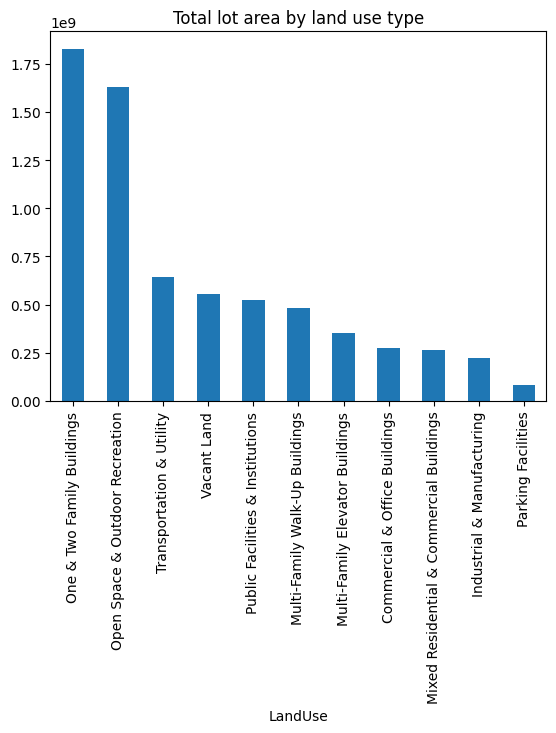

In [12]:
# there are many ways to visualize this data, and levels to refining the graphic style.
# This is the simplest possible example, using matplotlib to create a bar chart
pluto.groupby("LandUse").LotArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total lot area by land use type")

Text(0.5, 1.0, 'Total building area by land use type')

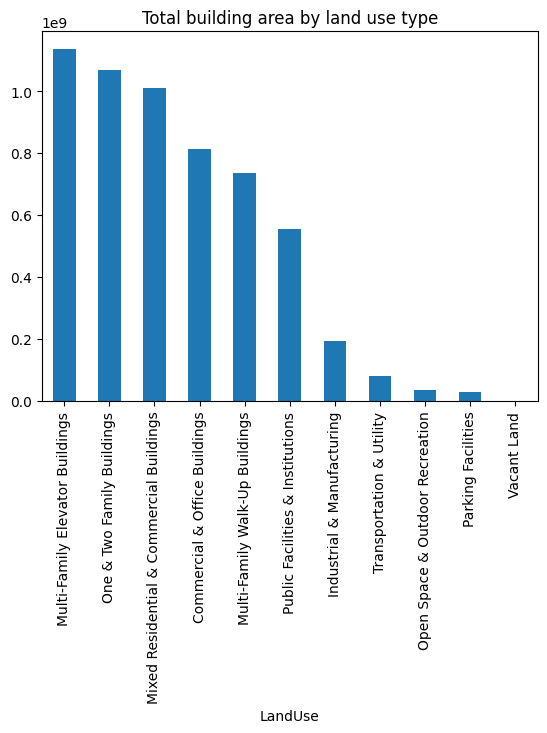

In [13]:
# now the same but for building area - note this is total building area, not average
pluto.groupby("LandUse").BldgArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total building area by land use type")

Below is a more complicated example where we can plot two variables against each other to compare.

Note how we are manipulating a "figure" (`fig`) and "axes" (`ax`) object to create a more complex plot. This is a common pattern in data visualization libraries like Matplotlib and Seaborn, where you can create a figure and then add multiple axes to it, each with its own plot. You can see several invocations of `ax` where we set various properties. 

We also use two copies of our pluto dataset as inputs - note how each copy is aggregated over a different variable. 

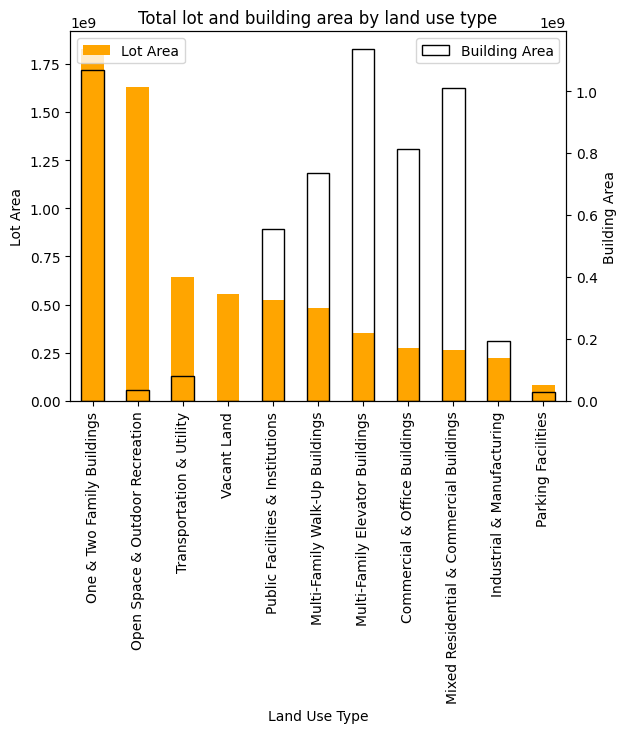

In [14]:
# plot both lot and building area on the same plot with a secondary y-axis
fig, ax = plt.subplots()
by_lot_area = pluto.groupby("LandUse").LotArea.sum().sort_values(ascending=False)

by_lot_area.plot.bar(ax=ax, color="orange")

# get order to apply below
order = {v: i for i, v in enumerate(by_lot_area.index)}

ax.set_ylabel("Lot Area")
ax.set_xlabel("Land Use Type")

ax2 = ax.twinx()
pluto.groupby("LandUse").BldgArea.sum().reindex(by_lot_area.index).plot.bar(
    ax=ax2, edgecolor="black", color="none"
)
ax2.set_ylabel("Building Area")

plt.title("Total lot and building area by land use type")

# add legends
ax.legend(["Lot Area"], loc="upper left")
ax2.legend(["Building Area"], loc="upper right")

## numeric column


We can use the `describe()` function to get a summary of the numeric columns in the dataset.

In [15]:
pluto["NumFloors"].describe()

count    856819.000000
mean          2.357554
std           2.012707
min           0.000000
25%           2.000000
50%           2.000000
75%           2.500000
max         104.000000
Name: NumFloors, dtype: float64

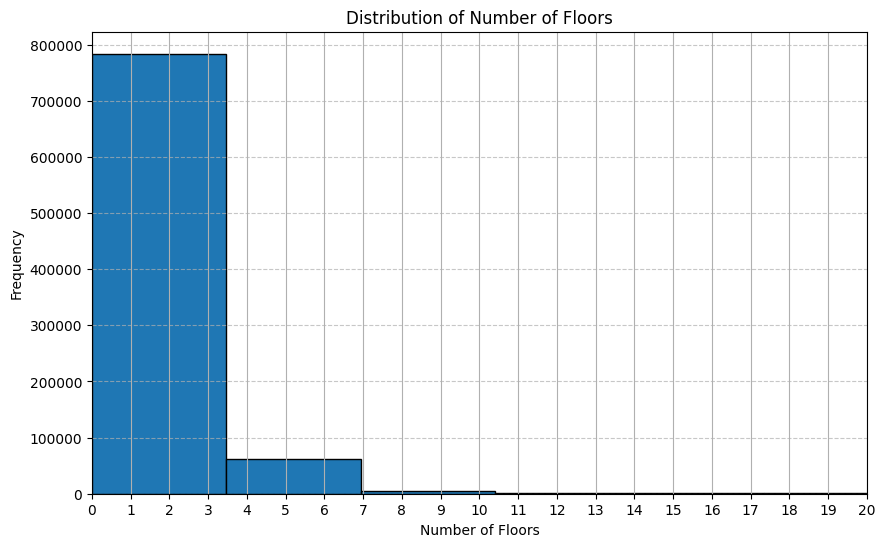

In [16]:
# We can see that the average number of floors is 2.35, but the maximum is 104! and that the majority of buildings have 1-3 floors.
# Let's visualize the distribution of the number of floors using a histogram
plt.figure(figsize=(10, 6))
pluto["NumFloors"].hist(bins=30, edgecolor="black")
plt.title("Distribution of Number of Floors")
plt.xlabel("Number of Floors")
plt.ylabel("Frequency")
plt.xlim(0, 20)  # limit x-axis to 20 for better visibility
plt.xticks(range(0, 21))  # set x-ticks to integers from 0 to 20
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Interactive plotting

We can use the `pygwalker` library to create an interactive visualization of the data. Especially as we are becoming familiar with the dataset, this can be a useful way to explore the data and see how different variables relate to each other.

In [17]:
# pygwalker doesn't suppert geospatial data directly, so we need to drop the geometry column.
# Be sure to keep a copy of the original data, we'll need it later!
pluto_non_spatial = pluto.drop(columns=["geometry"])

# Invoke pygwalker, begin exploring the data interactively
pyg.walk(pluto_non_spatial)

Box(children=(HTML(value='\n<div id="ifr-pyg-00063772a6200358TZtbAj1ahBGfrpJM" style="height: auto">\n    <hea…

> ## Your turn:
> - Take a few minutes to explore the dataset on your own.
> - Try creating graphs that show the relationship between different variables.
> - Let's discuss what you find or what you're exploring. 

# Mapping


## Creating a static map


KeyboardInterrupt: 

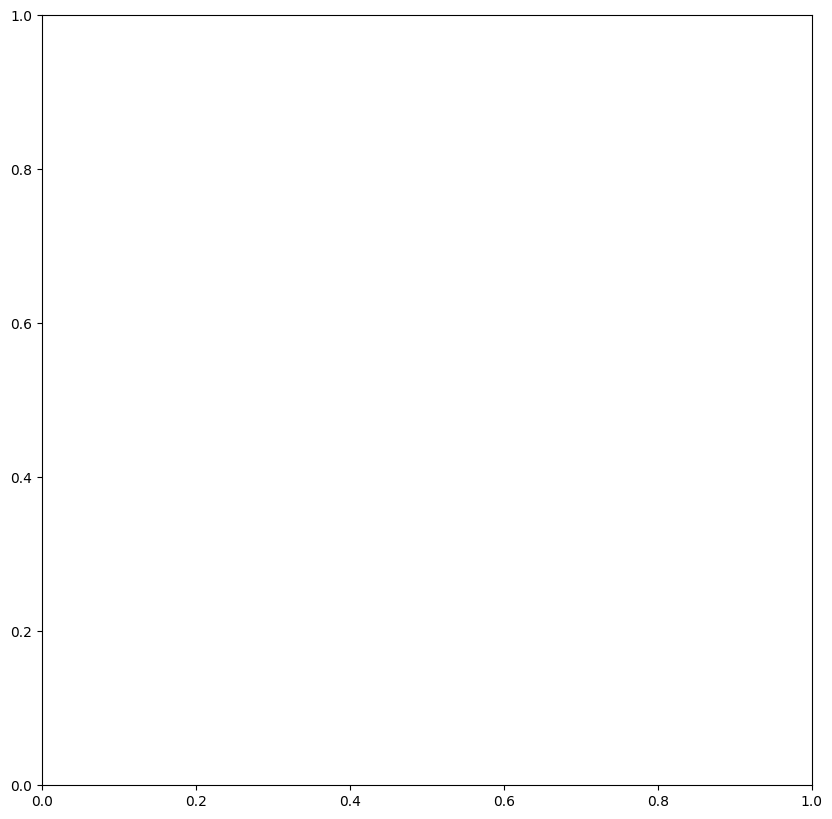

In [ ]:
# In this example, we are using matplotlib to map our pluto data.
# Under the hood, matplotlib is drawing each individual polygon (>800,000),
# which is resource intensive and hard to discern on a map! This is a good
# place to start, but we'll soon move on to more advanced mapping techniques.


pluto.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC MapPLUTO")

In [19]:
cmap = {
    "One & Two Family Buildings": "#ffff00",
    "Multi-Family Walk-Up Buildings": "#fffb00",
    "Multi-Family Elevator Buildings": "#ffc800",
    "Mixed Residential & Commercial Buildings": "#ff4000",
    "Commercial & Office Buildings": "#ff0000",
    "Industrial & Manufacturing": "#7700ff",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#001580",
    "Open Space & Outdoor Recreation": "#219F21",
    "Parking Facilities": "#A6A6AB",
    "Vacant Land": "#222222",
    "Unknown": "#000000",
}

In [20]:
pluto.fillna({"LandUse": "Unknown"}, inplace=True)

In [21]:
pluto.LandUse.unique()

array(['Public Facilities & Institutions',
       'Multi-Family Walk-Up Buildings',
       'Mixed Residential & Commercial Buildings',
       'One & Two Family Buildings', 'Multi-Family Elevator Buildings',
       'Vacant Land', 'Commercial & Office Buildings',
       'Open Space & Outdoor Recreation', 'Transportation & Utility',
       'Parking Facilities', 'Unknown', 'Industrial & Manufacturing'],
      dtype=object)

In [22]:
# here we make a new column called "color" that maps the LandUse values to colors
pluto["color"] = pluto["LandUse"].map(cmap)

In [23]:
pluto["color"].unique()

array(['#001580', '#fffb00', '#ff4000', '#ffff00', '#ffc800', '#222222',
       '#ff0000', '#219F21', '#808080', '#A6A6AB', '#000000', '#7700ff'],
      dtype=object)

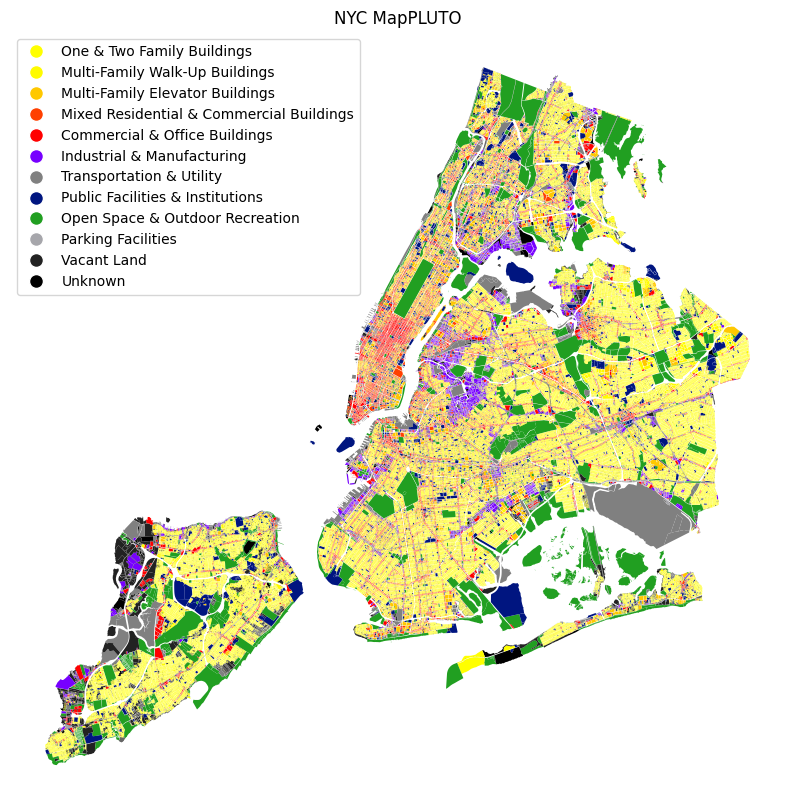

In [24]:
ax = pluto.plot(
    color=pluto["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC MapPLUTO")


# populate legend items based on dict from above
legend_colors = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

## Your turn:

- map a numeric column using a continuous colormap for Queens. See here for a list and discussion of colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
- What patterns emerge?


In [ ]:
pluto.plot(column="LotArea")

In [ ]:
pluto.LotArea.plot.hist(bins=100, log=True)

# prep for interactive mapping


In [25]:
pluto_wgs = pluto.to_crs("epsg:4326")

## visualize a categorical variable


In [26]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

In [27]:
cmap_rgb

{'One & Two Family Buildings': [255, 255, 0],
 'Multi-Family Walk-Up Buildings': [255, 251, 0],
 'Multi-Family Elevator Buildings': [255, 200, 0],
 'Mixed Residential & Commercial Buildings': [255, 64, 0],
 'Commercial & Office Buildings': [255, 0, 0],
 'Industrial & Manufacturing': [119, 0, 255],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [0, 21, 128],
 'Open Space & Outdoor Recreation': [33, 159, 33],
 'Parking Facilities': [166, 166, 171],
 'Vacant Land': [34, 34, 34],
 'Unknown': [0, 0, 0]}

In [28]:
len(pluto_wgs[pluto_wgs["LandUse"].isna()])

0

In [34]:
pluto.fillna({"LandUse": "Unknown"}, inplace=True)

## now, we can plot the data using lonboard to create an interactive map


In [32]:
df = pluto_wgs[["LandUse", "geometry"]].copy()
df["LandUse"] = df["LandUse"].astype("category")

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(
        df["LandUse"],
        cmap=cmap_rgb,
    ),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x1a3300280>
[
  [
    0,
  …

## visualize a continuous variable


In [35]:
df = pluto_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x1a3301660>
[
  [
    210,
…

In [36]:
df = pluto_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)


layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
    extruded=True,
    get_elevation=pluto_wgs["NumFloors"] * 14,
)
m = Map(layer)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x1a3301fc0>
[
  49,
 …

In [37]:
pluto_wgs[pluto_wgs.YearBuilt < 1970]

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,color
0,MN,1,10,101,1000500,10005000003,5,1000,02,1,...,1,24v1.1,None,40.688766,-74.018682,None,0.0,7.478663e+06,"POLYGON ((-74.01208 40.69205, -74.01215 40.692...",#001580
1,MN,97,33,101,1001501,10015013007,15.01,3014,02,1,...,1,24v1.1,t,40.707789,-74.002009,None,0.0,2.839154e+03,"POLYGON ((-74.00202 40.70791, -74.00198 40.707...",#fffb00
2,MN,97,35,101,1001501,10015013007,15.01,3014,02,1,...,1,24v1.1,t,40.707728,-74.002117,None,0.0,2.531493e+03,"POLYGON ((-74.00213 40.70784, -74.00199 40.707...",#ff4000
3,MN,97,36,101,1001501,10015013007,15.01,3014,02,1,...,1,24v1.1,t,40.707687,-74.002207,None,0.0,1.825158e+03,"POLYGON ((-74.00231 40.70776, -74.00224 40.707...",#ff4000
4,MN,97,43,101,1001501,10015013007,15.01,3014,02,1,...,1,24v1.1,t,40.707374,-74.002705,None,0.0,1.057095e+03,"POLYGON ((-74.00271 40.70731, -74.00278 40.707...",#ff4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856813,SI,8050,72,503,5024800,50248001014,248,1016,31,51,...,None,24v1.1,None,40.509091,-74.250634,None,0.0,7.766762e+03,"POLYGON ((-74.25065 40.50927, -74.25039 40.509...",#ffff00
856814,SI,8050,76,503,5024800,50248001014,248,1016,31,51,...,None,24v1.1,None,40.509174,-74.250491,None,0.0,3.533919e+03,"POLYGON ((-74.25065 40.50927, -74.25055 40.509...",#ffff00
856816,SI,8050,83,503,5024800,50248001014,248,1016,31,51,...,None,24v1.1,None,40.509152,-74.250189,None,0.0,5.078841e+03,"POLYGON ((-74.24997 40.50916, -74.25004 40.509...",#ffff00
856817,SI,8050,86,503,5024800,50248001014,248,1016,31,51,...,None,24v1.1,None,40.508963,-74.250274,None,0.0,1.318642e+04,"POLYGON ((-74.24983 40.50903, -74.2499 40.5090...",#ffff00


In [38]:
df = pluto_wgs[pluto_wgs.YearBuilt > 2010][["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
    extruded=True,
    get_elevation=df["NumFloors"] * 14,
)
m = Map(layer)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x1a3302c80>
[
  98,
 …

In [40]:
pluto_wgs.YearBuilt.nunique()

252

In [41]:
def categorize_buildings(r):
    if r.YearBuilt < 1900:
        return "Pre-1900"
    elif r.YearBuilt < 1950:
        return "1900-1950"
    elif r.YearBuilt < 2000:
        return "1950-2000"
    else:
        return "Post-2000"

In [42]:
pluto_wgs["year_category"] = pluto_wgs.apply(categorize_buildings, axis=1)

In [43]:
pluto_wgs.year_category.value_counts()

year_category
1900-1950    482376
1950-2000    231164
Pre-1900      79173
Post-2000     64106
Name: count, dtype: int64

In [44]:
year_built_ma = {
    "Pre-1900": "[255,0,0]",
    "1900-1950": "#00ff00",
    "1950-2000": "#0000ff",
    "Post-2000": "#ff00ff",
}

In [ ]:
df = pluto_wgs[["year_category", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["year_category", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["year_category"], cmap=cmap_rgb),
)
m = Map(layer)
m

## your turn: can you make the above show in 3d?

- see here for some tips: https://developmentseed.org/lonboard/latest/examples/overture-maps/#imports


In [ ]:
cmap_rgb

In [ ]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]
layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
    extruded=True,
    get_elevation=pluto_ogrio_wgs["NumFloors"] * 14,
)
m = Map(layer)

m